# Digit Classifier w/ PyTorch

We are going to do a few things here:

- We want to train a model to identify digits for the individual sudoku cell image that the Recognizer has prepared.
- We want to use this as a Tensorflow Model in the C++

So what are the steps?

1. First train the sudoku digit classifier (aka SudokuNet) model using the MNIST dataset
2. Save the model to the /models folder as a .pb file

## Part I: Setup

### Dependencies

In [60]:
import torch
import torchvision
import numpy as np
from sklearn.metrics import accuracy_score

### Prepare the dataset

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Get the dataset

In [7]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./dataset', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./dataset', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100.1%

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


28.4%

113.5%

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw


100.4%

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


180.4%

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


### Plot some samples

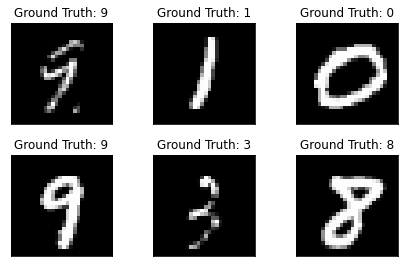

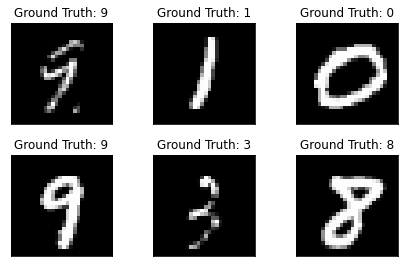

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Part II: Build the network

### Setup

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Now initialize the network and the optimizer

In [46]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

## Part III: Train the network

In [47]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [48]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [31]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [49]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3107, Accuracy: 1262/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333493
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.336111
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.268786
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.316574
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.281197
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.251939
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.214621
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.134260
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.088837
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.954796
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.894333
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.857848
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.627908
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.592888
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.576041
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.537441
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.278772
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.474201
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.241927
Train Epoch: 1 [12160

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.230766
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.239059
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.100822
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.473916
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.396232
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.214313
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.258166
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.233318
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.370846
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.187995
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.217795
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.246197
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.303433
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.465315
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.166248
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.236345
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.263673
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.322328
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.259809
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.456124


## Part IV: Evaluate performance & further training

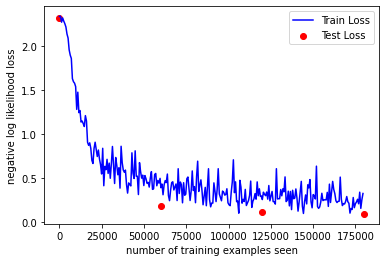

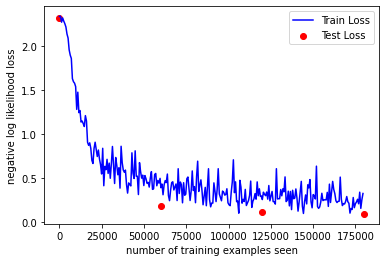

In [50]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

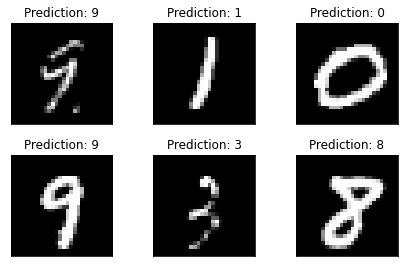

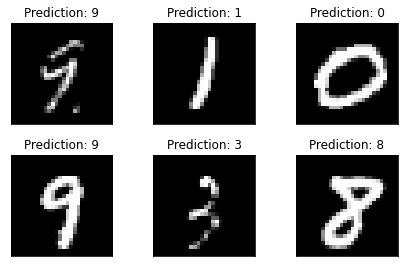

In [51]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Continued training

In [52]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [53]:
network_state_dict = torch.load("./models/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("./models/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [54]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.177970
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.248308
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.232535
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.178674
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.147127
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.405638
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.393413
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.131311
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.138642
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.305040
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.194281
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.158631
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.324652
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.206452
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.322441
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.267098
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.368400
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.290436
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.334524
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.235367
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [45440/60000 (76%)]	Loss: 0.130570
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.170726
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.277976
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.505844
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.201183
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.268753
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.199351
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.191692
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.108903
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.338666
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.193366
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.228882
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.099485
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.092746
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.223553
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.108859
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.109225
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.183485
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.178969
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.240682


Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.222514
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.275299
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.259809
Train Epoch: 7 [31360/60000 (52%)]	Loss: 0.231813
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.191782
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.119148
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.161393
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.124755
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.144340
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.089673
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.127128
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.200112
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.132903
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.274428
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.185916
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.205451
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.124233
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.341190
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.166640
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.089922


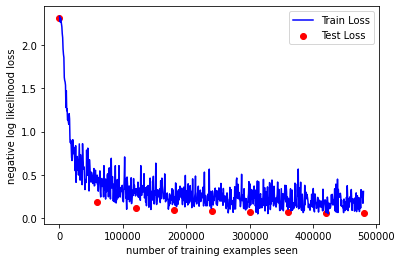

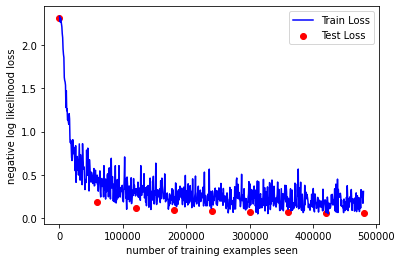

In [55]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

## Prep to save the model to be used in C++

In [56]:
example_image, example_label = next(iter(train_loader))
# run the tracing
traced_script_module = torch.jit.trace(network, example_image)
# save the converted model
traced_script_module.save("./models/converted_model.pt")